In [81]:
# In [1] - Import Libraries

import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [82]:
# In [2] - Check TenserFlow and GPU steup

print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected!")
    for gpu in gpus:
        print("→", gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU.")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU detected. Check your CUDA/cuDNN and environment config.")

TensorFlow version: 2.16.2
No GPU detected. Check your CUDA/cuDNN and environment config.


In [83]:
# In [3] - Load and Inspect Training Data

train_df = pd.read_csv("emnist-balanced-train.csv", header=None)
print(train_df.head())
print(train_df.describe())
print(train_df.shape)


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   45    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   36    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   43    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
                0         1         2         3         4              5    \
count  112800.00000  112800.0  112800.0  112800.0  112800.0  112800.000000   
mean       23.00000       0.0       0.0       0.0       0.0       0.001365   
std        13.56472       0.0       0.0       0.0       0

In [84]:
# In (Ekstra, lav en ny fil med data fra kaggle, ChatGPT)

# Indholdet du vil gemme i tekstfilen
content = """0 48
1 49
2 50
3 51
4 52
5 53
6 54
7 55
8 56
9 57
10 65
11 66
12 67
13 68
14 69
15 70
16 71
17 72
18 73
19 74
20 75
21 76
22 77
23 78
24 79
25 80
26 81
27 82
28 83
29 84
30 85
31 86
32 87
33 88
34 89
35 90
36 97
37 98
38 100
39 101
40 102
41 103
42 104
43 110
44 113
45 114
46 116
"""

# Filnavn
filename = "emnist-balanced-mapping.txt"

# Opret og skriv til filen
with open(filename, "w", encoding="utf-8") as f:
    f.write(content)

print("Filen er oprettet:", filename)


Filen er oprettet: emnist-balanced-mapping.txt


In [85]:
# In [4] - Create Dictionary

label_map = pd.read_csv("emnist-balanced-mapping.txt", 
                        delimiter=' ', index_col=0, header=None)

In [86]:
# In [5]

label_dictionary = {i : chr(label) for i, label in enumerate(label_map[1][10:36])}
print(label_dictionary)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [87]:
# In [6] - Filter and Preprocess Data

train_df_new = train_df[train_df[0].isin(np.arange(10, 36))]
train_df_new = train_df_new.reset_index(drop=True)

In [88]:
# In [7]

train_df_new[0] = train_df_new[0] - 10
print(train_df_new.head())
print(train_df_new[0].describe())
print(train_df_new.shape)

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   22    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   10    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
count    62400.00000
mean        12.50000
std          7.50006
min          0.00000
25%          6.00000
50%         12.50000
75%         19.00000
max         25.00000
Name: 0, dtype: float64
(62400, 785)


In [89]:
# In [8] - Split Features And Labels

x_train = train_df_new.loc[:, 1:]
y_train = train_df_new.loc[:, 0]
print(x_train.shape, y_train.shape)

(62400, 784) (62400,)


In [90]:
# In [9] - Inspect A Sample Image

sample_image = x_train.iloc[667]
sample_label = y_train.iloc[667]
print(sample_image.shape, sample_label)

(784,) 4


In [91]:
# In [10] - Image Preprocessing Functions

def dimension(image):
    W = 28
    H = 28
    image = np.array(image).reshape(W, H)
    return image

def flip_and_rotate(image):
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

Label entry No. 667: E


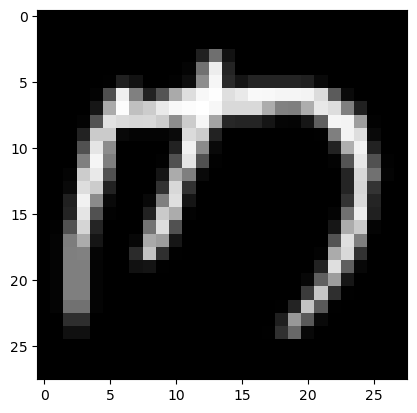

In [92]:
# In [11] - Visualize Original Sample Image

print("Label entry No. 667:", label_dictionary[sample_label])
plt.imshow(dimension(sample_image), cmap=plt.cm.gray)
plt.show()

Label entry 667: E


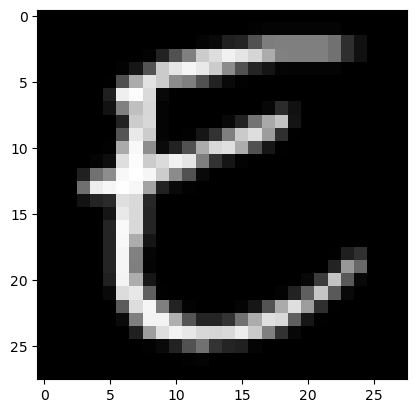

In [93]:
# In [12] - Visualize Preprossed Sample Image

print("Label entry 667:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(dimension(sample_image)), cmap=plt.cm.gray)
plt.show()

In [94]:
# In [13] - Reshape Training Image

x_train = np.apply_along_axis(dimension, 1, x_train)
print(x_train.shape)

(62400, 28, 28)


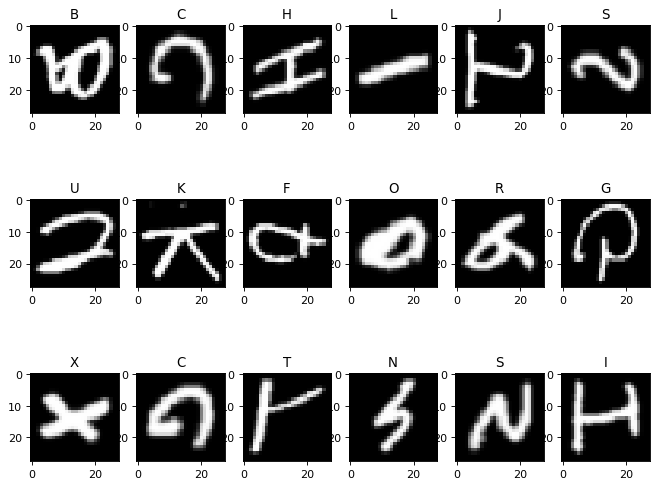

In [95]:
# In [14] - Visualize Multiple Training Images (Pre-Reshape)

plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3, 6, i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])
plt.show()

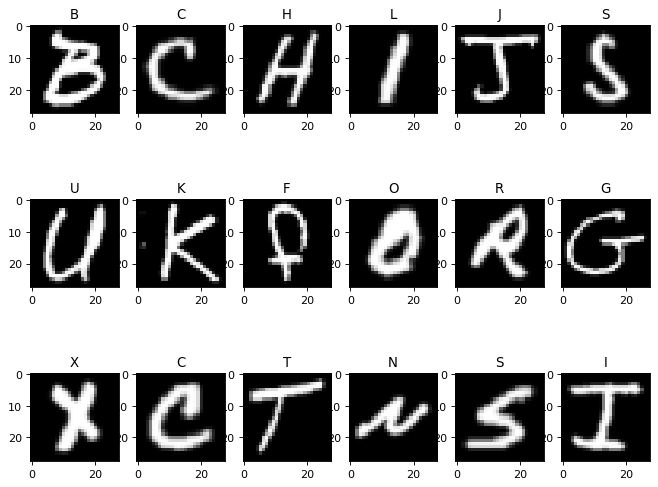

In [96]:
# In [15] - Apply Flip and Rotate to Training Images and Visualize Preprocessed Training Images

x_train = np.array([flip_and_rotate(img) for img in x_train])

plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3, 6, i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])
plt.show()

In [97]:
# In [16] - Load And Inspect Test Data

test_df = pd.read_csv("emnist-balanced-test.csv", header=None)
print(test_df.head())
print(test_df.describe())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   41    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   39    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   26    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   44    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
                0        1        2        3        4             5    \
count  18800.000000  18800.0  18800.0  18800.0  18800.0  18800.000000   
mean      23.000000      0.0      0.0      0.0      0.0      0.006064   
std       13.565021      0.0      0.0      0.0      0.0      0.528828   

In [98]:
# In [17] - Filter And Preprocess Test Data

test_df_new = test_df[test_df[0].isin(np.arange(10, 36))]
test_df_new = test_df_new.reset_index(drop=True)

In [99]:
# In [18] 

test_df_new[0] = test_df_new[0] - 10
print(test_df_new.head())

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    2    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [100]:
# In [19] - Prepare Test Features And Labels

x_test = test_df_new.loc[:, 1:]
y_test = test_df_new.loc[:, 0]

In [101]:
# In [20]

x_test = np.array([dimension(img) for img in x_test.to_numpy()])
x_test = np.array([flip_and_rotate(img) for img in x_test])
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_test: (10400, 28, 28)
y_test: (10400,)


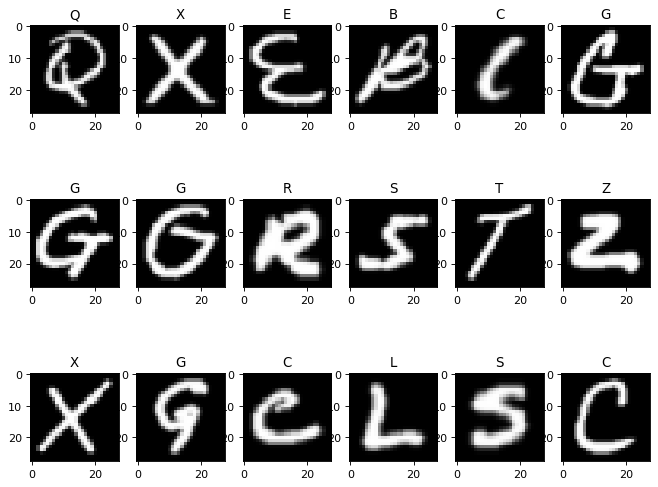

In [102]:
# In [21] - Visualize Test Images

plt.figure(figsize=(10, 8), dpi=80)
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_test.iloc[i]])
plt.show()

In [103]:
print(y_test.unique())
print(label_dictionary.keys())


[16 23  4  1  2  6 17 18 19 25 11 10 13 15 21  7 24  8  9 22  3 14  0 20
  5 12]
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])


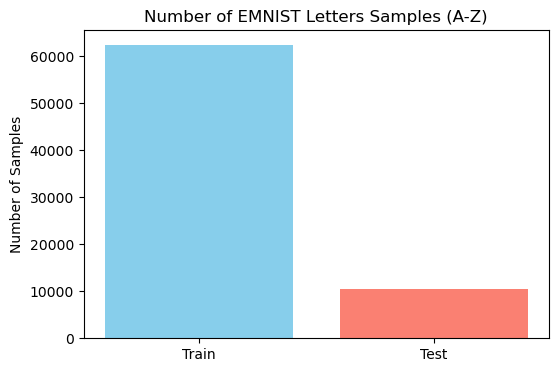

In [ ]:
# In [22] - Compare Train and Test Sample Size

plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Test'], [y_train.shape[0], y_test.shape[0]], 
        color=['skyblue', 'salmon'])
plt.title('Number of EMNIST Letters Samples (A-Z)')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
# In [23] - Normalize Data

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# In [24] - Check Numbers Of Classes

number_of_classes = y_train.nunique()
print(number_of_classes)

26


In [107]:
# In [25] - Reshape Data for Models

W = 28
H = 28
x_train_cnn = x_train.reshape(-1, W, H, 1)
x_test_cnn = x_test.reshape(-1, W, H, 1)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(x_train_flat.shape)
print(x_test_flat.shape)

(62400, 28, 28, 1)
(10400, 28, 28, 1)
(62400, 784)
(10400, 784)


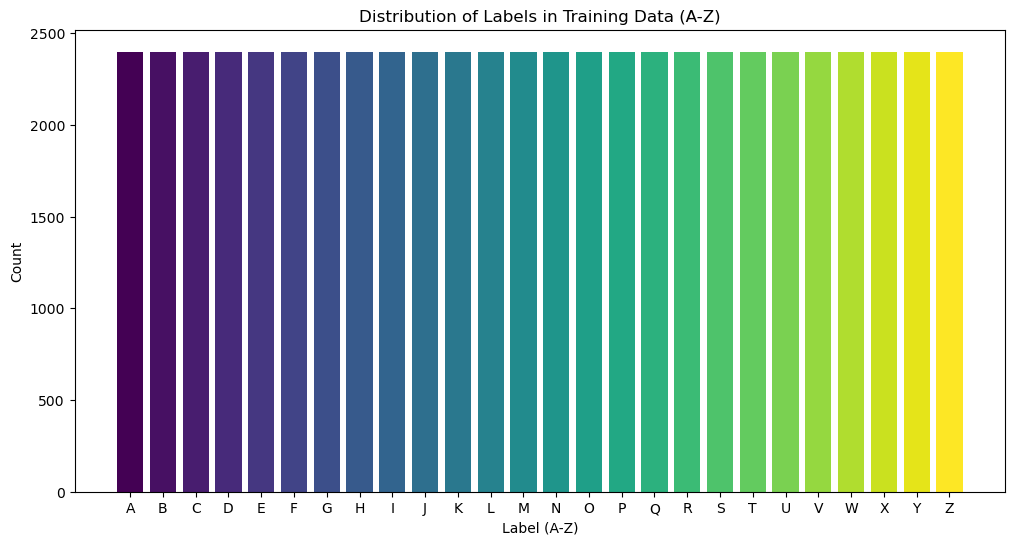

In [109]:
# In [26] - Visualize Training Label Distribution

unique_labels, counts = np.unique(y_train, return_counts=True)
letter_labels = [label_dictionary[label] for label in unique_labels]
plt.figure(figsize=(12, 6))
plt.bar(letter_labels, counts, color=plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_labels))))
plt.xlabel("Label (A-Z)")
plt.ylabel("Count")
plt.title("Distribution of Labels in Training Data (A-Z)")
plt.show()

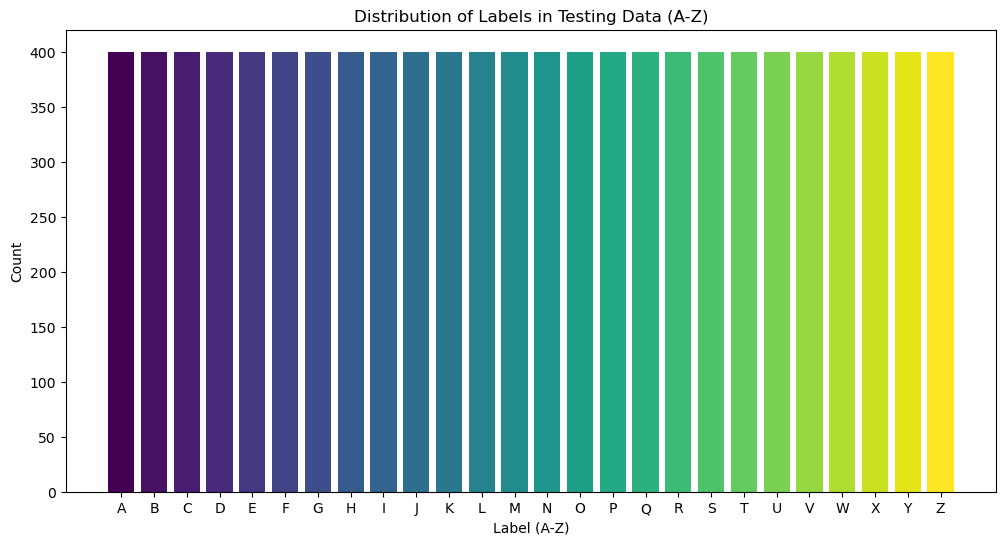

In [110]:
# In [27] - Visualize Test Label Distribution

unique_labels, counts = np.unique(y_test, return_counts=True)
letter_labels = [label_dictionary[label] for label in unique_labels]
plt.figure(figsize=(12, 6))
plt.bar(letter_labels, counts, color=plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_labels))))
plt.xlabel("Label (A-Z)")
plt.ylabel("Count")
plt.title("Distribution of Labels in Testing Data (A-Z)")
plt.show()

In [113]:
# In [28] - Define and Train Neural Network(estimated runtime is 2 mins)

# THIS MODEL IS FOR EXPERIMENTATION ONLY THIS IS NOT THE ACTUAL MODEL THAT WILL BE USED IN GUI ITS JUST
# USED TO SHOW HOW CNN MODEL OUTPERFORMS ALL THE COMMON MODELS FOR IMAGE PROCESSING TASKS. 
# Purpose: Defines a simple feedforward neural network with two hidden layers (128 and 64 units) and a softmax output layer. 
# Compiles the model with the Adam optimizer and sparse categorical crossentropy loss.
# Trains the model for 10 epochs with a batch size of 32, using the test set for validation.


nn_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax')
])


In [115]:
# In [29] - 

nn_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [116]:
# In [30] - 

history_nn = nn_model.fit(x_train_flat, y_train, epochs=10, batch_size=32,
                          validation_data=(x_test_flat, y_test))

Epoch 1/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7911 - loss: 0.7110 - val_accuracy: 0.8553 - val_loss: 0.4817
Epoch 2/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8900 - loss: 0.3545 - val_accuracy: 0.8926 - val_loss: 0.3512
Epoch 3/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9109 - loss: 0.2789 - val_accuracy: 0.9023 - val_loss: 0.3222
Epoch 4/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9220 - loss: 0.2345 - val_accuracy: 0.9110 - val_loss: 0.2992
Epoch 5/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9305 - loss: 0.2077 - val_accuracy: 0.9083 - val_loss: 0.2971
Epoch 6/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9368 - loss: 0.1859 - val_accuracy: 0.9159 - val_loss: 0.2949
Epoch 7/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9406 - loss: 0.1692 - val_accuracy: 0.9095 - val_loss: 0.3081
Epoch 8/10
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9445 - loss: 0

In [117]:
# In [31] - Evaluate Neural Network

loss_nn, accuracy_nn = nn_model.evaluate(x_test_flat, y_test)
print(f"Neural Network Model Accuracy on Test Set: {accuracy_nn}")

325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9107 - loss: 0.3294
Neural Network Model Accuracy on Test Set: 0.9106730818748474


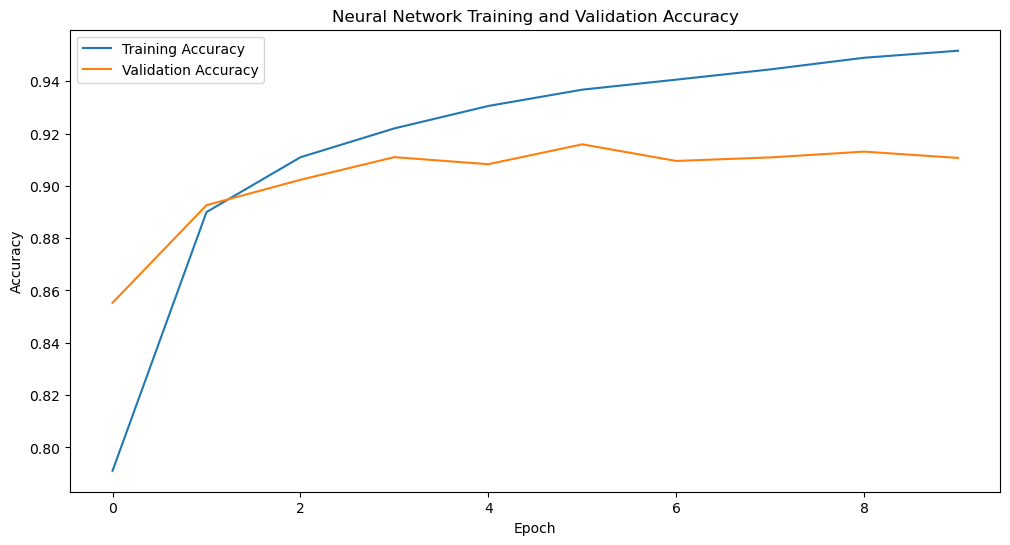

In [118]:
# In [32] - Plot Neural Network Accuracy

plt.figure(figsize=(12, 6))
plt.plot(history_nn.history['accuracy'], label='Training Accuracy')
plt.plot(history_nn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Neural Network Training and Validation Accuracy')
plt.legend()
plt.show()

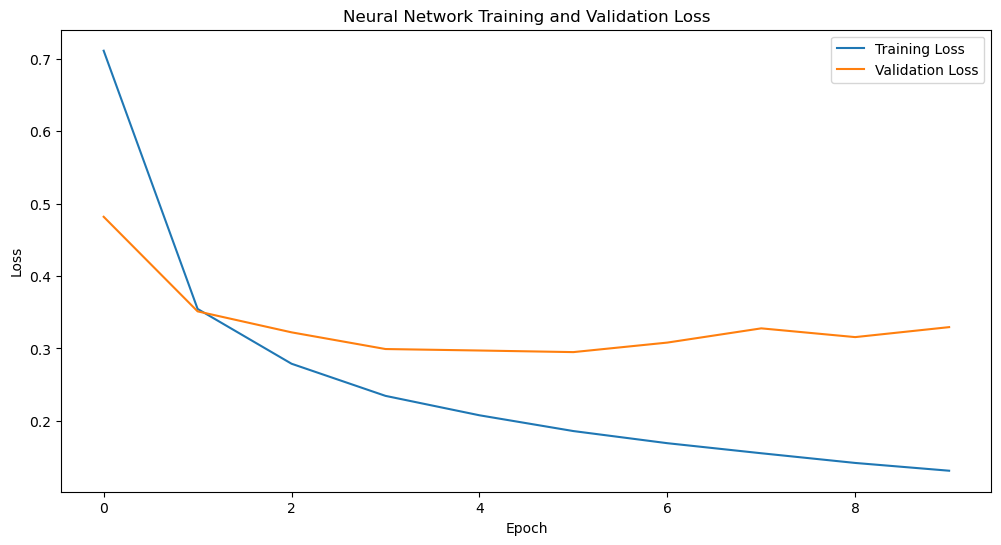

In [119]:
# In [33] - Plot Neural Network Loss

plt.figure(figsize=(12, 6))
plt.plot(history_nn.history['loss'], label='Training Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training and Validation Loss')
plt.legend()
plt.show()

**Input 34 - 36 hører denne tekst med:**

THIS MODEL IS FOR EXPERIMENTATION ONLY THIS IS NOT THE ACTUAL MODEL THAT WILL BE USED IN GUI ITS JUST USED TO SHOW HOW CNN MODEL OUTPERFORMS ALL THE COMMON MODELS FOR IMAGE PROCESSING TASKS. 

In [ ]:
# In [34] - Train and Evaluate Decision Tree(estimated runtime is 1 min

# Purpose: Trains a Decision Tree classifier with entropy criterion on the flattened training data. Evaluates it on the test set and prints the accuracy.

dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_model.fit(x_train_flat, y_train)
y_pred_dt = dt_model.predict(x_test_flat)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Model Accuracy on Test Set: {accuracy_dt}")

Decision Tree Model Accuracy on Test Set: 0.7205769230769231


In [ ]:
# In [35] - Train and Evaluate Random Forest(estimated runtime is 2 mins)

# Purpose: Trains a Random Forest classifier with 30 trees on the flattened training data. Evaluates it on the test set and prints the accuracy.

rf_model = RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=42)
rf_model.fit(x_train_flat, y_train)
y_pred_rf = rf_model.predict(x_test_flat)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Model Accuracy on Test Set: {accuracy_rf}")

Random Forest Model Accuracy on Test Set: 0.8800961538461538


In [ ]:
# In [36] - Train and Evaluate XGBoost(estimated runtime is 8 mins)

# Purpose: Trains an XGBoost classifier with 30 estimators on the flattened training data. Evaluates it on the test set and prints the accuracy.

xgb_model = XGBClassifier(n_estimators=30, random_state=42, n_jobs=-1)
xgb_model.fit(x_train_flat, y_train)
y_pred_xgb = xgb_model.predict(x_test_flat)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy on Test Set: {accuracy_xgb}")

XGBoost Model Accuracy on Test Set: 0.869326923076923


Tilbage til den samlede kode

In [123]:
# In [37] - Define CNN Model(estimated runtime is 15 mins)

def cnn(input_shape=(28, 28, 1), num_classes=26):
    inputs = layers.Input(shape=input_shape)
    
    # Conv Block 1
    x = layers.Conv2D(60, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(60, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Conv Block 2
    x = layers.Conv2D(100, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(100, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Conv Block 3
    x = layers.Conv2D(200, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(200, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    # Residual Connection
    shortcut = layers.Conv2D(200, (1, 1), padding='same')(inputs)
    shortcut = layers.MaxPooling2D((8, 8))(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    
    # Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(400, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [124]:
# In [38] - 

cnn_model = cnn(input_shape=(28, 28, 1), num_classes=number_of_classes)
cnn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        600 │ input_layer_3[0]… │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        240 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     32,460 │ batch_normalizat… │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        240 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ max_pooling2d[0]… │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     54,100 │ dropout[0][0]     │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        400 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     90,100 │ batch_normalizat… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        400 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 100) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 100) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 200) │    180,200 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 200) │        800 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 200) │    360,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 200) │        800 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │        400 │ input_layer_3[0]

 Total params: 1,454,166 (5.55 MB)

 Trainable params: 1,451,526 (5.54 MB)

 Non-trainable params: 2,640 (10.31 KB)

In [125]:
# In [39] - Train CNN Model

model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = cnn_model.fit(
    x_train_cnn, y_train,
    batch_size=512,
    epochs=50,
    validation_data=(x_test_cnn, y_test),
    callbacks=[model_checkpoint, lr_scheduler]



    
)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5724 - loss: 11.7529

122/122 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.7662 - loss: 8.6228 - val_accuracy: 0.0385 - val_loss: 9.1888 - learning_rate: 0.0010
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9151 - loss: 2.4281 - val_accuracy: 0.0385 - val_loss: 6.7887 - learning_rate: 0.0010
Epoch 3/50
  1/122 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.9414 - loss: 1.3842

KeyboardInterrupt: 

In [ ]:
# In [40] - 

